In [14]:
from fastai import *
from fastai.vision import *
import numpy as np

### The data
*Some redundant code here below*

In [2]:
folder = 'abrams'
file = 'urls_abrams.csv'

In [5]:
folder = 'leopard'
file = 'ulrs_leopard.csv'

In [8]:
folder = 't90'
file = 'urls_t90.csv'

Run this below per each category (annoying, could make it more efficient):

In [9]:
# Create the folder
path = Path('data/tanks')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

### Download images


In [4]:
# Download M1 Abrams pics
download_images(Path('../input/urls_abrams.csv'), dest, max_pics=200)

Error https://militaryedge.org/wp-content/uploads/2013/10/m1A2.jpg HTTPSConnectionPool(host='militaryedge.org', port=443): Max retries exceeded with url: /wp-content/uploads/2013/10/m1A2.jpg (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'ssl3_get_server_certificate', 'certificate verify failed')],)",),))


In [7]:
# Download Leopard 2A6 pics
download_images(Path('../input/urls_leopard.csv'), dest, max_pics=200)

In [10]:
# Download T-90 pics
download_images(Path('../input/urls_t90.csv'), dest, max_pics=200)

### Remove images that can't be opened

In [11]:
path.ls()

[PosixPath('data/tanks/leopard'),
 PosixPath('data/tanks/t90'),
 PosixPath('data/tanks/abrams')]

In [ ]:
# Class names for labels. MUST be same as folder name in `path`
classes = ['abrams', 'leopard', 't90']

In [13]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_worders=8)

abrams


cannot identify image file <_io.BufferedReader name='data/tanks/abrams/00000032.png'>
leopard


t90


cannot identify image file <_io.BufferedReader name='data/tanks/t90/00000068.jpg'>


### View data

In [15]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2,
                                 ds_tfms=get_transforms(), size=224, num_workers=4)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (236 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
leopard,leopard,leopard,leopard,leopard
Path: data/tanks;

Valid: LabelList (59 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
abrams,t90,leopard,leopard,abrams
Path: data/tanks;

Test: None

In [16]:
# Check data classes
data.classes

['abrams', 'leopard', 't90']

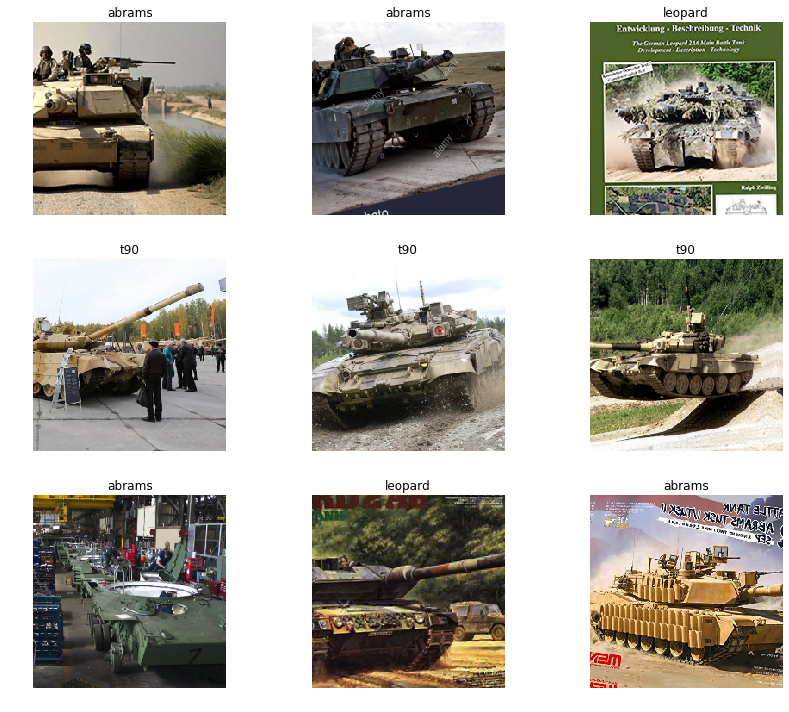

In [18]:
data.show_batch(rows=3, figsize=(12, 10))

In [19]:
# Get some stats
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['abrams', 'leopard', 't90'], 3, 236, 59)

Training: 236  
Validation: 59

### Train model with "resnet34"

In [20]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
87306240it [00:03, 26030197.34it/s]


In [21]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.486511,1.087024,0.474576,00:09
1,1.227789,0.876289,0.593220,00:08
2,1.070155,0.791088,0.644068,00:08
3,0.924969,0.764455,0.677966,00:09


In [23]:
learn.save('stage1')

In [24]:
learn.unfreeze()

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


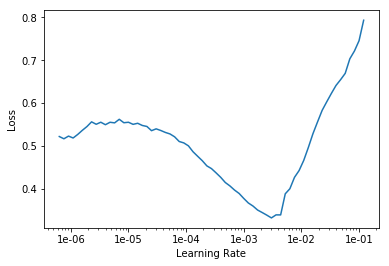

In [26]:
learn.recorder.plot()

Train again using learning rate from above plot:

In [30]:
learn.fit_one_cycle(10, max_lr=slice(1e-05, 1e-02))

epoch,train_loss,valid_loss,accuracy,time
0,0.320640,0.592315,0.762712,00:10
1,0.319146,0.506268,0.813559,00:09
2,0.291952,0.491710,0.847458,00:08
3,0.235881,0.828614,0.762712,00:08
4,0.220944,1.031097,0.728814,00:08
5,0.186535,0.952789,0.745763,00:08
6,0.165401,0.783510,0.796610,00:08
7,0.145051,0.740473,0.830508,00:08
8,0.131972,0.716743,0.847458,00:08
9,0.119648,0.693708,0.847458,00:09


In [31]:
learn.save('stage2')

### Interpretation

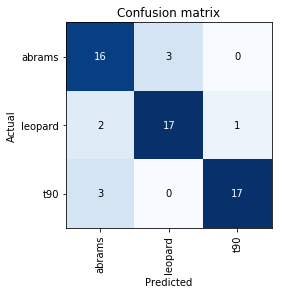

In [32]:
learn.load('stage2')

interp = ClassificationInterpretation.from_learner(learn)

# Confusion matrix
interp.plot_confusion_matrix()

### Clearning up

Get the file paths from the `top_losses`:

In [39]:
from fastai.widgets import *

losses, indxs = interp.top_losses()
top_losses_paths = data.valid_ds.x[indxs]

In [40]:
# Pass to the FileDeleter widget from `fastai.widgets`
fd = FileDeleter(file_paths=top_losses_paths)

NameError: name 'FileDeleter' is not defined

In [44]:
# Fastai verison
__version__

'1.0.51'

`fastai.widgets` probably don't work in Kaggle kernels. Watch 34:00 in [Lesson 2](https://course.fast.ai/videos/?lesson=2) to see `FileDeleter` widget in action.

### Putting model in production

In [45]:
data.classes

['abrams', 'leopard', 't90']

In [46]:
path.ls()

[PosixPath('data/tanks/leopard'),
 PosixPath('data/tanks/t90'),
 PosixPath('data/tanks/abrams'),
 PosixPath('data/tanks/models')]

In [ ]:
# Use CPU if want
# fastai.defaults.device = torch.device('cpu')

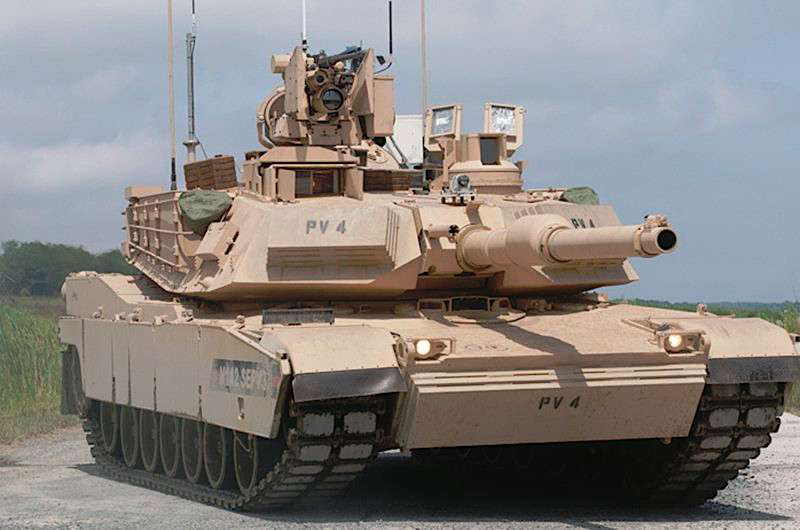

In [54]:
# Load a random image
img = open_image(path/'abrams'/'00000022.jpg')
img

In [49]:
# Grabs one single image at a time
data2 = ImageDataBunch.single_from_classes(path, classes, ds_tfms=get_transforms(), size=244)   # Prams must be same as before
data2.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/tanks;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/tanks;

Test: None

In [51]:
learn = cnn_learner(data2, models.resnet34)

In [52]:
# Load weights
learn.load('stage2')

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/tanks;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/tanks;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(


In [55]:
# Predicting
pred_class, pred_idx_, outputs = learn.predict(img)
pred_class

Category abrams

Predicted successfully that that picture of tank is of class `abrams`.

Go to [Lesson 2 forum thread](https://forums.fast.ai/t/wiki-lesson-2/9399) or the [Jupyter notebook](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb) and see a small example of how to deploy in production using [Starlette](https://www.starlette.io) web app framework.